## Modelos Lineales - Parte 1. Regresión

## Ejemplo de ajuste lineal

Para empezar a ganar confianza con los modelos lineales, vamos a ajustar dos modelos: uno lineal y otro polinomial. 
Para cancherear, vamos a decir que vamos a entrenar los modelos con datos sintéticos, y vamos a evaluar la performance del modelo con otro set de datos (datos de test).

Como de costumbre, primero hacemos algunas importanciones y tuneos (esto está sacado casi literal del Géron):

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "05_ModelosLineales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "plots", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.makedirs(IMAGES_PATH, exist_ok=True)
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

Generemos los datos sintéticos, a partir de un modelo conocido (ground truth), con coeficiente $m$ y $b$:

In [2]:
import numpy.random as rr

# Parámetros de la ground truth
b = 4 #ordenada al origen
m = 5 #pendiente

# Número de datos
n = 100

# creo un numero (de 100 elementos) random entre 0 y 1 lo multiplico por 2
x_ = 2 * np.random.rand(n, 1)

# El modelo real (ground truth)
t_ = b + m * x_ #es una recta

# Agregemos error normal a los datos
t_ += np.random.randn(n, 1)

En este punto, vamos a separar 20% de los datos para usar de test, y quedarnos solo con el 80% de datos de entrenamiento. En el contexto de un ajuste lineal, esto parace una exageración de nomenclatura, pero es la que vamos a usar después para casos más complejos.

In [6]:
def elegir_test(data, fraccion, seed=1234):

    # Fijar el seed para ser reproducible
    import numpy.random as rr
    if seed is not None:
        rr.seed(seed)
    
    # Permuta los índices para elegir al azar
    ind = rr.permutation(len(data))
    # Calcula el número de elementos en el set de test
    ntest = int(len(data) * fraccion)
    
    # Construye los índices para cada conjunto
    indices_train = ind[ntest:]
    indices_test = ind[:ntest]
    return data[indices_train], data[indices_test]

Una implementación muy similar aparece en el paquete <tt>Scikit-Learn</tt>, que vamos a usar mucho de ahora en más. Veamos que ambas cosas dan lo mismo

In [14]:
# Construye array con los x y los t --> los junto verticalmente
print("shape de x_",x_.shape)
print("shape de t_",t_.shape)

data = np.hstack([x_, t_])
print("shape de data",data.shape)

# Nuestra implementación
data_train, data_test = elegir_test(data, 0.2)
print("shape de data_train",data_train.shape)
print("shape de data_test",data_test.shape)



shape de x_ (100, 1)
shape de t_ (100, 1)
shape de data (100, 2)
shape de data_train (80, 2)
shape de data_test (20, 2)


Implementación en scikit-learn:

In [16]:

from sklearn.model_selection import train_test_split

#le pido a sktlearn que separe el conjunto de datos en train y test
sk_train, sk_test = train_test_split(data, test_size=0.2, random_state=1234)

#verifico que lo que hicimos nosotros y lo que hace sktlearn es lo mismo, veo que sean iguales
for tipo, nos, sk in zip(['Train', 'Test'], [data_train, data_test],[sk_train, sk_test]):
    print('Los conjuntos de {} son idénticos: {}.'.format(tipo, np.allclose(nos, sk)))

Los conjuntos de Train son idénticos: True.
Los conjuntos de Test son idénticos: True.


Text(0,0.5,'t')

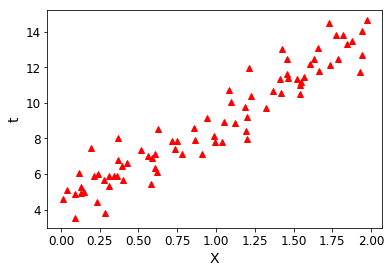

In [19]:
# Y veamos finalmente a qué se parecen los datos de entrenamiento
plt.plot(data_train[:, 0], data_train[:, 1], '^r')
plt.xlabel('X')
plt.ylabel('t')

Vamos a ajustar los datos con un modelo lineal simple (que además es el modelo correcto):

$$
y(\mathbf{x}, w_0, w_1) = w_0 + w_1 x\;\;.
$$

En la nomenclatura que vimos en la clase, tenemos $\phi_0(\mathbf{x}) = 1$, y $\phi_1(\mathbf{x}) = x$, y en ese caso recuperamos la ecuación conocida:

$$
y(\mathbf{x}, \mathbf{w}) = \sum_{j=0}^1 w_j \phi_j(\mathbf{x})\;\;.
$$

La suposición del modelo es que la variable $t$ puede escribirse como 

$$
t = y(\mathbf{x}, \mathbf{w}) + \epsilon\;\;,
$$
donde suponemos que el error $\epsilon$ es una variable aleatoria, distribuida como una Gaussiana centrada en cero y con precisión $\beta$.

En ese caso, la función de distribución para $t$ es:

$$
p(t \vert \mathbf{x}, \mathbf{w}, \beta) = \mathcal{N}(t \vert y(\mathbf{x}, \mathbf{w}), \beta^{-1})\;\;,
$$
por lo que, usando las propiedades de la Gaussiana, vemos que

$$
\mathbb{E}[t|x] = y(\mathbf{x}, \mathbf{w})\;\;,
$$

Vimos que la solución que maximiza la verosimilitud se obtiene a través de las ecuaciones normales:

$$
\mathbf{w}_\mathrm{ML} = \left(\mathbf{\Phi}^T \mathbf{\Phi}\right)^{-1} \mathbf{\Phi}^T \mathbf{t}\;\;,
$$
donde $\mathbf{\Phi}$ es la llamada matriz de diseño, que para este caso es muy sencilla:

$$
\mathbf{\Phi} = 
\begin{pmatrix} 
1 & x[0] \\
1 & x[1] \\
\vdots & \vdots \\
1 & x[n-1] \\
\end{pmatrix}
\quad
\;\;.
$$

Calculemos la solución:

In [22]:
x = data_train[:, 0].reshape(len(data_train), 1)
t = data_train[:, 1].reshape(len(data_train), 1)

# Primero definamos la matriz uniendo dos vectores
phi = np.hstack([x*0.0 + 1, x])

# Ahora calculemos el producto de phi por su transpuesta y verifiquemos que la forma es la correcta
pp = np.dot(phi.T, phi)

# y el producto entre phi y el vector t
yy = np.dot(phi.T, t)

print(phi.shape, pp.shape, yy.shape)

(80, 1)
(80, 2) (2, 2) (2, 1)


Ahora, en lugar de calcular la inversa y multiplicar, resolvemos el sistema:

$$
\left(\mathbf{\Phi}^T \mathbf{\Phi}\right) \mathbf{w}_\mathrm{ML} = \mathbf{\Phi}^T \mathbf{t}\;\;.
$$

Para eso, usamos <tt>np.linalg.solve</tt>:

In [23]:
wml = np.linalg.solve(pp, yy)
print(wml)

[[4.28703884]
 [4.74498439]]


Vemos que obtenemos valores parecidos al modelo verdadero. Podemos calcular alguna medición del alejamiento de los datos de entrenamiento del modelo. Lo típico, justificado por la maximización de la verosimilitud, es calcular el Root-Mean-Square Error (RMSE):

$$
\mathrm{RMSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\left(y(\mathbf{x_i}, \mathbf{w_\mathrm{ML}}) - t_i\right)^2}
$$

In [24]:
def rmse(t, tpred):
    return np.sqrt(np.sum((tpred - t)**2) / len(tpred))

print('El RMSE en el conjunto de training es: {:.3f}'.format(rmse(t, phi @ wml)))

El RMSE en el conjunto de training es: 0.920


Hacer ambas cosas es lo mismo: True


Text(0,0.5,'t')

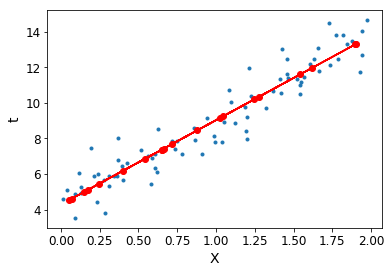

In [30]:
plt.plot(x, t, '.')

# Calculemos la predicción del modelo sobre los datos de testeo
x_test = data_test[:, 0].reshape(len(data_test), 1)
phi_test = np.hstack([x_test*0.0 + 1, x_test])

# La predicción
t_pred = phi_test @ wml

# Vean que lo que estamos haciendo es multiplicar cada elemento de wml por 
# la columna correspondiente de la matriz de diseño, y sumando
t_pred2 = np.array([wml[i] * phi_test[:, i] for i in range(phi.shape[1])])
t_pred2 = np.sum(t_pred2, axis=0)

# Veamos que es lo mismo
print('Hacer ambas cosas es lo mismo: {}'.format(np.allclose(t_pred, t_pred2[:, np.newaxis])))

plt.plot(x_test, t_pred, 'o-r')
plt.xlabel('X')
plt.ylabel('t')

Por último, podemos calcular el RMSE del conjunto de testeo, usando el valor verdadero que habíamos generado, <tt>t_test</tt>

In [26]:
t_test = data_test[:, 1].reshape(len(data_test), 1)

print('El RMSE en el conjunto de training es: {:.3f}'.format(rmse(phi_test @ wml, t_test)))

El RMSE en el conjunto de training es: 0.815


***
***

## Ejemplo de ajuste multivariado

Vamos a hacer un ejemplo práctico que utiliza modelos lineales para predecir el valor de casas en California. Es un ejemplo clásico, que está descripto con detalle en el libro de Géron.

### Objetivo
El objetivo es entrenar un algoritmo que permita predecir el precio de las casas en California, usando datos de un censo. El censo provee información sobre el costo medio de las casas en cada distrito cubierto por el censo, junto con otros datos relevantes, como cercanía al mar, e ingreso promedio.

El sistema tiene el objetivo de remplazar estimaciones hechas a mano por expertos, que en general salen muy mal.

En este punto, Géron nos invita a pensar sobre el tipo de algoritmo que tenemos que implementar:

- ¿Es supervisado o no supervisado? ¿Alguna otra cosa?

- ¿Debe ser un algoritmo de clasificación o de regresión? ¿O Alguna otra cosa?

- ¿Podemos aprender en batch, o sería mejor algo de aprendizaje online (es decir, progresivo)?

### Obtención de los datos

Vamos a bajar los datos del repositorio (sólo si estás corriendo esto en Colab).

In [31]:
import os
import tarfile

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/exord/UNSAM_IA/master/"
HOUSING_PATH = os.path.join(".", "datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    #urllib.request.urlretrieve(housing_url, tgz_path)
    !wget http://raw.githubusercontent.com/exord/UNSAM_IA/master/datasets/housing.tgz -P {housing_path}
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [32]:
fetch_housing_data()

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


FileNotFoundError: [Errno 2] No such file or directory: '.\\datasets\\housing\\housing.tgz'

In [36]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

Como es la costumbre, después de cargar los datos vamos a ver las primeras filas, y usemos el método <tt>info</tt> para tener más información.

In [38]:
housing = load_housing_data()
housing.head()

FileNotFoundError: File b'.\\datasets\\housing\\housing.csv' does not exist

In [ ]:
housing.info()

Vemos que la tabla tiene 20640 entradas, con 10 columnas cada una. Todas las columnas son numéricas menos la última "ocean_proximity". Además, vemos que hay algunos registros faltantes en  "total_bedrooms". 

En el head no se puede ver los valores que toma la columna "ocean_proximity"; veamos qué valores hay y cuántos de cada uno. Para eso, usamos el método <tt>value_counts</tt>.

In [ ]:
housing["ocean_proximity"].value_counts()

Vayamos un poquito más allá y exploremos los datos numéricos un poco. Para eso, existen métodos de <tt>pandas</tt> que son muy útiles. Algunos ya los vimos, como <tt>describe</tt>.

In [ ]:
housing.describe()

Algunas cosas:

- El método evita los valores que no están presentes (por eso el "count" de "total_bedrooms" es 20433).

- Como verán, el ingreso medio fue preprocesados, para tener valores entre 0.5 y 15.0, en lugar de los verdaderos ingresos.

Otro método que está muy bueno es uno que te permite en un comando hacer los histogramas de todos los valores numéricos. Se trata de <tt>hist</tt>.

In [ ]:
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

Algunas cosas más:

- La edad media de las casas y el precio tienen un valor máximo. Esto se ve porque el último bin del histograma tiene muchos elementos. Esto es un problema para predecir valores por encima de $500'000.

- Algunos histogramas tienen colas muy largas, que van a ser problemáticas a la hora de hacer predicciones.

### Definición del conjunto de entrenamiento y de testeo

Ahora vamos a separar en dos la tabla de datos, definiendo un conjunto de entrenamiento y uno de testeo. Para eso, usamos la función de <tt>Scikit-Learn</tt> que vimos un poco más arriba (fíjense que funciona tanto para array como para dataframes de <tt>pandas</tt>).

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=445543)

Fijar el <tt>seed</tt> ayuda a que si corremos el algoritmo nuevamente, siempre llegemos a los mismos conjuntos. De lo contrario, cabe el riesgo que por correr muchas veces el algoritmo, el conjunto de prueba quede revelado.

Hay mucho más para decir de cómo se elige el conjunto de prueba, pero lo vamos a ir introduciendo de a poco en varios ejemplos a lo largo del curso.

Una cosa que vamos a discutir ahora rápidamente es la de elegir de forma estratificada en las dimensiones que sean relevantes. Supongamos que por alguna razón, creemos que una de las variables que serán determinantes en el precio de las casa sea el ingreso medio. Veamos:

In [ ]:
housing["median_income"].hist()

Ahora dividámoslo en categorias. Por ejemplo, cada 1.5 unidades de ingreso.

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [ ]:
housing["income_cat"].value_counts()

In [ ]:
housing["income_cat"].hist()

Y, de nuevo, podemos usar la magia de Scikit Learn para elegir conjuntos que respeten la proporción. Para eso, usamos la clase <tt>StratifiedShuffleSplit</tt>.

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

Comparemos ahora la fracción de casos en cada una de las cetegorías.

In [ ]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

In [ ]:
housing["income_cat"].value_counts() / len(housing)

Vemos que la cosa funciona: la fracción en cada categoría se mantiene.

Géron nos da una mano para mostrarnos la diferencia con haber elegido al azar.

In [ ]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=1234)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [ ]:
compare_props

In [ ]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

***

## Desafío (interludio)

Sin avanzar más en la exploración de datos, elijan un feature de la lista e intenten repetir lo que hicimos arriba para ajustar los valores de las casas con ese feature. 

Comparen el resultado usando el RSME

***

### Exploración de los datos

Antes de lanzarnos a entrenar un algoritmo de inteligencia artificial, es conveniente mirar los datos un poco más de cerca (el conjunto de testeo) para ganar alguna idea de cuál es el contenido.

Pero primero copiemos el set de entrenamiento, así podemos jugar sin miedo a romper nada.

In [ ]:
housing = strat_train_set.copy()

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
#save_fig("better_visualization_plot")

Se puede agregar mucha más información al scatterplot usando los tamaños ($s$) y los colores ($c$).

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
plt.legend()

Podemos calcular el coeficiente de correlación de Pearson ($\rho$) para cada par de columnas:

$$
\rho_{ij} = \frac{\mathrm{cov}(X_i, X_j)}{\sqrt{\mathrm{var}(X_i) \mathrm{var}(X_j)}}
$$

Si bien este coeficiente solo indica correlaciones lineales, nos da una idea de las dependencias de los datos.

In [ ]:
corr_matrix = housing.corr()

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

También podemos ver los plots de los datos de a pares.

In [ ]:
# from pandas.tools.plotting import scatter_matrix # For older versions of Pandas
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
#save_fig("scatter_matrix_plot")

Podemos concentrarnos en la correlación más fuerte, entre ingreso medio y valor medio de la casa.

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.axis([0, 16, 0, 550000])
#save_fig("income_vs_house_value_scatterplot")

Vemos varias cosas que ya habíamos mencionado:

- Una buena correlación.

- El hecho de que el valor máximo catalogado es de medio millón de dólares (vaya...)

- También vemos que hay algunas líneas horizontales, en distintos valores.

Todo esto lo vamos a tener que arreglar para poder trabajar con estos datos.

Además, podemos pensar en combinar las variables para tener elementos que sean más significativos.

#### Pregunta

¿Además de los que aparecen acá abajo, se les ocurre alguno más?

In [ ]:
# Cantidad de cuartos por casa
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
# Cantidad de cuartos por habitación
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# Cantidad de población por casa
housing["population_per_household"]=housing["population"]/housing["households"]

Veamos si alguno de estos tiene buena correlación con el precio medio de las casas.

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

In [ ]:
housing.plot(kind="scatter", x="rooms_per_household", y="median_house_value",
             alpha=0.2)
plt.axis([0, 5, 0, 520000])
plt.show()

In [ ]:
housing.describe()

### Preparación de datos

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

Hay una serie de tareas, la mayoría muy aburridas, que habría que hacer en el conjunto de datos que tenemos:

- Completar o filtrar datos faltantes (por ejemplo en el número de habitaciones totales, que vimos más arriba).

- Codificar los datos no numéricos (como la "proximidad a la playa").

- Uniformizar la escala de las "features".

Todo esto requiere una buena dosis de codeo. Por suerte, <tt>Scikit-Learn</tt> tiene toda un conjunto de Transformers que ayudan a hacer esto.

Por lo pronto, vamos a tomar el camino fácil, y nos vamos a deshacer de las filas que tienen datos faltantes y de las columnas con texto. 

(Ya veremos, con detalle, el uso de las clases de Scikit Learn).

In [ ]:
# Escribimos la condición de que ninguna columna esté vacía
# Para eso, buscamos el contrario de que cualquiera esté vacía.
# Por supuesto, lo mismo tenemos que hacer para las labels.
cond = ~housing.isnull().any(axis=1)
housing_tr = housing[cond]
housing_labels = housing_labels[cond]

# Ahora tiramos a la basura el feature "sea_proximity"
housing_num = housing_tr.drop('ocean_proximity', axis=1)

In [ ]:
housing_num.shape

Ahora estandarizamos los datos. Es decir, a cada columna le restamos su media y dividimos por su desviación estándard. Esto es típico y ayuda a la convergencia de los algoritmos.

Usamos más magia de <tt>ScikitLearn</tt>.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
hh = scaler.fit_transform(housing_num)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
housing_prepared = pd.DataFrame(hh, columns=housing_num.columns)
housing_prepared.head()

### Entrenamiento de un modelo lineal

Ahora tenemos los datos listos para usar en un modelo de regresión lineal.
Vamos a usar la implementación de SciKit Learn.

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

In [ ]:
# Veamos las predicciones de algunas filas y los valores reales
some_data = housing_prepared.iloc[:5]
some_labels = housing_labels.iloc[:5]

print("Predicciones:", lin_reg.predict(some_data))
print("Labels:", list(some_labels))

print("Diferencias porcentuales:", list(100*np.abs(lin_reg.predict(some_data) - some_labels)/some_labels))

Vamos a medir el valor del RMSE usando todo el set de training.

In [ ]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

Esto significa que el error medio en la predicción de los valores es de casi $70000. No es muy bueno, pero es lo que hay con un modelo tan simple.

Es interesante ver la distribución de las diferencias absolutas entre las predicciones y los labels.

In [ ]:
abserror = np.abs(housing_predictions - housing_labels)
print('Max', abserror.max())
print('Median', np.median(abserror))
print('25th-percentile', np.percentile(abserror, 25))
print('75th-percentile', np.percentile(abserror, 75))
print('90th-percentile', np.percentile(abserror, 90))

h = plt.hist(np.abs(housing_predictions - housing_labels), 100)

In [ ]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

### Evaluación en el conjunto de test

Ahora retomemos el conjunto de test y evaluemos las predicciones. 
Por supuesto, antes tenemos que hacer el mismo procesamiento a los datos.

In [ ]:
housing_test = strat_test_set.drop("median_house_value", axis=1) # drop labels for test set
housing_test_labels = strat_test_set["median_house_value"].copy()

cond = ~housing_test.isnull().any(axis=1)
housing_test_tr = housing_test[cond]
housing_test_labels = housing_test_labels[cond]

# Ahora tiramos a la basura el feature "sea_proximity"
housing_test_num = housing_test_tr.drop('ocean_proximity', axis=1)

# Usamos el mismo scaler (ahora el método es fit en lugar de fit_transform)
hh = scaler.transform(housing_test_num)

# Esto devuelve un array, que hay que transformar de nuevo a un DataFrame
housing_test_prepared = pd.DataFrame(hh, columns=housing_test_num.columns)

Ahora sí, finalmente, calculemos las predicciones con nuestro modelo

In [ ]:
housing_test_predictions = lin_reg.predict(housing_test_prepared)

abserror = np.abs(housing_test_predictions - housing_test_labels)

print('Test Absolute Differences')
print('Max', abserror.max())
print('Median', np.median(abserror))
print('25th-percentile', np.percentile(abserror, 25))
print('75th-percentile', np.percentile(abserror, 75))
print('90th-percentile', np.percentile(abserror, 90), '\n')

lin_mse = mean_squared_error(housing_test_labels, housing_test_predictions)
print('RMSE (test)', np.sqrt(lin_mse))
print('MAE (test)', mean_absolute_error(housing_test_labels, housing_test_predictions))